### (3) Geostatistical modeling

This notebook will combine the Geo-structural model (2) and the results of the variogram analysis (3) to create a full 3D porosity model of the New Jersey Shelf using Gaussian simulation. The result will be a single realization of this model. Resolution can be adjusted.

In [1]:
# Import dependencies
import gempy as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import gstools as gs
import pyvista as pv
import pyvistaqt as pvqt
import PVGeo
import scipy.spatial.distance as dist
import scipy
from scipy.optimize import curve_fit
import datetime

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.precision", 2)

No module named 'osgeo'


In [2]:
### User-defined functions
def perform_SGS(x, y, z, strike_angle, dip_angle, cond_data, x_range, y_range, z_range):
    '''
    Function to create Random field based on GSTools routines.
    
        Arguments:
            x,y,z: Grid coordinates to estimate over.
            strike_angle, dip_angle: Rotational angles of Shelf system in degrees.
            cond_data: Conditioning data for Random field.
            x_range, y_range, z_range: directional variogram ranges.
        Returns:
            cond_srf: GSTools Spatial Random field object (3D)
    '''
    
    # Convert given rotation angle to radians
    strike_angle = np.deg2rad(strike_angle)
    dip_angle = np.deg2rad(dip_angle)
    
    # Angle naming to GSTools
    alpha = 0
    beta = strike_angle
    gamma = dip_angle
    
    # Coordinate preparation
    coordinates = np.array([x,y,z])
    coordinates = coordinates.swapaxes(0,1)
    
    # Conditioning data preparation
    cond_pos = cond_data[:,:3]
    cond_pos = cond_pos.transpose(1,0)
    cond_val = cond_data[:,3]
    
    # Set conditioning data and anisotropies
    model = gs.Exponential(dim=3, var=np.var(cond_val), len_scale=[x_range, y_range, z_range], angles=[alpha, beta, gamma])
    krige = gs.krige.Ordinary(model, cond_pos, cond_val)
    cond_srf = gs.CondSRF(krige)
   
    # Perform SGS 
    cond_srf((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')
    
    return cond_srf

def plot_block_model(field):
    '''
    Function for plotting 3D Block Model based on GStools result
    
    Arguments:
        field: GSTools Spatial Random Field object (3D)
    Returns:
        p: pyvista plotter with voxel model
    '''
    
    # Create pyvista mesh for field
    pc = field.to_pyvista()
    
    # Find voxel size
    spacing = lambda arr: np.unique(np.diff(np.unique(arr)))
    voxelsize = spacing(pc.points[:,0]), spacing(pc.points[:,1]), spacing(pc.points[:,2])

    # Pvgeo way of voxelizing semi-unstructured grid
    grid = PVGeo.filters.VoxelizePoints(dx=voxelsize[0][0], dy=voxelsize[1][0], dz=voxelsize[2][0], estimate=False).apply(pc)

    # Plotting
    #p = pv.Plotter(notebook=True)
    p = pvqt.BackgroundPlotter()
    #p.add_mesh(grid, opacity=1, show_edges=True)
    cmap = plt.cm.get_cmap("viridis", 5)
    #p.add_mesh(grid, opacity=1, show_edges=False, lighting=False, cmap=cmap)
    p.add_mesh(grid, opacity=1, show_edges=False, lighting=False, cmap="viridis") # continuous cmap
    #p.add_mesh(pc, point_size=5, cmap='viridis')
    
    return p

def extract_domain(sol, unit):
    '''
    Extract domain coordinates from gempy model by unit name
    
    Arguments:
        sol: Gempy solution object.
        unit: string name of gempy surface
    Returns:
        dom_x, dom_y, dom_z: coordinates of domain
    '''

    # Round Lithlogy block from gempy
    rounded_lithblock = sol.lith_block.round(0)
    rounded_lithblock = rounded_lithblock.astype(int)

    # Mask by array of input surfaces (by id, can be from different series)
    mask = np.isin(rounded_lithblock, [ref_dict[unit]])

    # Get coordinates by mask
    dom_grid = sol.grid.values[mask]

    # Split coordiantes
    dom_x = dom_grid[:,0]
    dom_y = dom_grid[:,1]
    dom_z = dom_grid[:,2]

    return dom_x, dom_y, dom_z

### 1. Reload and recalcualte Geo-structural model

In [3]:
# Load model from notebook (2)
geo_data = gp.load_model('Geo-structural model NJ shelf')

Active grids: ['regular']


In [4]:
%%time
# Set interpolator
interp_data = gp.set_interpolator(geo_data, compile_theano=True,
                                  theano_optimizer='fast_compile')

Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                                       values
range                              150731.18
$C_o$                            540949761.9
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3]
CPU times: total: 20.9 s
Wall time: 21.8 s


In [17]:
# Ajdust resolution here if necessary
geo_data.set_regular_grid([0, 69000, 0, 134000, -1700, 0], [138,268,85]);

# Alternatives 
#geo_data.set_regular_grid([0, 69000, 0, 134000, -1700, 0], [69,134,42]) # Half resolution
#geo_data.set_regular_grid([41999, 42000, 0, 134000, -1700, 0], [2,1600,320]) # 2.5D model

Active grids: ['regular']


In [18]:
#%%time
# Compute model solution
sol = gp.compute_model(geo_data)

In [5]:
import pickle
save_path_model = "Data/Geo-structural model/Geo-structural_model_NJ_shelf.pkl"
# Load geo_model from a file
with open(save_path_model, 'rb') as f:
    geo_data = pickle.load(f)

In [6]:
# View model 3D 
gpv = gp.plot_3d(geo_data, ve=30, plotter_type='background', show_data=False)
gpv.p.camera_position = (320, 200, 3)

### 2. Loading and preparing conditioning data (Porosity well data)

In [7]:
# Load data 
df = pd.read_csv("Data/Wells/Complete_set_corrected.csv")
#df = pd.read_csv("Data/Wells/Complete_set_corrected_M28blind.csv")  #uncomment for blind test data

df.head()

,X,Y,Z,Porosity,Sequence,Well
0,28200,76200,-372.13,10.7,m54,m28
1,28200,76200,-568.73,13.3,m58,m28
2,28200,76200,-671.83,15.0,m58,m28
3,28200,76200,-693.95,15.6,m58,m28
4,28200,76200,-692.00,16.0,m58,m28


### 2.1 Detrend

In [8]:
# Routine for detrending from notebook (3)

# Trend models
def exponential_trend(x, a, b):
    return a*np.exp(b*x)

def linear_trend(x, a, b):
    return a+b*x

# Vertical trend
xdata = df["Z"].values*(-1)# make depth positve
ydata = df["Porosity"].values

p0 = [41,0.001]
popt_exp, pcov_exp = curve_fit(exponential_trend, xdata, ydata, p0)

df["Residuals_temp"] = df["Porosity"].values - exponential_trend(df["Z"].values, *popt_exp)
df.head()

# Horizontal trend
xdata = np.unique(df["Y"].values)
ydata = np.array([np.mean(df[df["Well"]=="m27"]["Residuals_temp"]), 
                  np.mean(df[df["Well"]=="m28"]["Residuals_temp"]), 
                  np.mean(df[df["Well"]=="m29"]["Residuals_temp"])])
#ydata = np.array([np.mean(df[df["Well"]=="m27"]["Residuals_temp"]),  
#                  np.mean(df[df["Well"]=="m29"]["Residuals_temp"])])
popt_lin, pcov_lin = curve_fit(linear_trend, xdata, ydata)


df["Residuals"] = df["Residuals_temp"].values - linear_trend(df["Y"].values, *popt_lin)

df.head()

,X,Y,Z,Porosity,Sequence,Well,Residuals_temp,Residuals
0,28200,76200,-372.13,10.7,m54,m28,-35.98,-34.42
1,28200,76200,-568.73,13.3,m58,m28,-33.72,-32.16
2,28200,76200,-671.83,15.0,m58,m28,-32.20,-30.64
3,28200,76200,-693.95,15.6,m58,m28,-31.64,-30.08
4,28200,76200,-692.00,16.0,m58,m28,-31.24,-29.68


### 2.2 n-score transform

In [10]:
# Routine for n-score transform from notebook (3)

def cdf(d, bins=12 ):
    N = len( d )
    counts, intervals = np.histogram( d, bins=bins )
    h = np.diff( intervals ) / 2.0
    f, finv = np.zeros((N,2)), np.zeros((N,2))
    idx, k, T = 0, 0, float( np.sum( counts ) )
    for count in counts:
        for i in range( count ):
            x = intervals[idx]+h[0]
            y = np.cumsum( counts[:idx+1] )[-1] / T
            f[k,:] = x, y 
            finv[k,:] = y, x
            k += 1
        idx += 1
    return f, finv

def fit(d):
    x, y = d[:,0], d[:,1]
    def f(t):
        if t <= x.min():
            return y[ np.argmin(x) ]
        elif t >= x.max():
            return y[ np.argmax(x) ]
        else:
            intr = scipy.interpolate.interp1d( x, y )
            return intr(t)
    return f

# transform data to normal dist
def to_norm( data, bins=10000):
    mu = np.mean( data )
    sd = np.std( data )
    z = ( data - mu ) / sd
    f, inv = cdf( z, bins=bins )
    z = scipy.stats.norm(0,1).ppf( f[:,1] )
    z = np.where( z==np.inf, np.nan, z )
    z = np.where( np.isnan( z ), np.nanmax( z ), z )
    param = ( mu, sd )
    return z, inv, param, mu, sd
 
# transform data from normal dist back
def from_norm( data, inv, param, mu, sd ):
    h = fit( inv )
    f = scipy.stats.norm(0,1).cdf( data )
    z = [ h(i)*sd + mu for i in f ]
    return z

In [11]:
# N-score transformation all
por_residuals_norm_transform, inv, param, m, sd = to_norm(df["Residuals"].values)

# Add to dataframe
df["Nscore Residuals"]=por_residuals_norm_transform

df.head()

,X,Y,Z,Porosity,Sequence,Well,Residuals_temp,Residuals,Nscore Residuals
0,28200,76200,-372.13,10.7,m54,m28,-35.98,-34.42,-3.07
1,28200,76200,-568.73,13.3,m58,m28,-33.72,-32.16,-2.86
2,28200,76200,-671.83,15.0,m58,m28,-32.20,-30.64,-2.73
3,28200,76200,-693.95,15.6,m58,m28,-31.64,-30.08,-2.63
4,28200,76200,-692.00,16.0,m58,m28,-31.24,-29.68,-2.55


### 2.3 Reference dictionary (between Geo-strucutral model and borehole data)

In [12]:
# Dictionary reference between unit name and gempy reference id
ref_dict = dict(geo_data.surfaces.df[['surface', 'id']].values)
ref_dict2 = {
    "m1": "m1",
    "m41": "m4_1",
    "m5": "m5",
    "m54": "m5_4",
    "m58": "m5_8",
    "m6": "m6",
    "o1": "o1",}

print(ref_dict)


{'SeaFloor': 1, 'm1': 2, 'm4_1': 3, 'm5': 4, 'm5_4': 5, 'm5_8': 6, 'm6': 7, 'o1': 8, 'basement': 9}


### 3. Loading variogram parameters

In [13]:
# Getting varigoram parameters from (3)
variogram_results = pd.read_csv("Results/Variogram results table.csv", index_col=0)
variogram_results

,Sequence,Model,Z Range (Well Data),Y Angle (Attr),Y Range (Attr),X Angle (Attr),X Range (Attr),Anisotropy Ratio (X/Y/Z),Comment
0,m1,Exponential,13.67,-0.12,2403.51,0.00,3796.74,[278 176 1],*Strike direction corrected (underlying sequen...
1,m41,Exponential,13.67,-0.19,2393.22,-0.01,3796.74,[278 175 1],NaN
2,m5,Exponential,13.67,-0.11,3446.76,-0.00,4180.39,[306 252 1],*Strike direction corrected (underlying sequen...
3,m54,Exponential,13.67,-0.07,2433.96,0.08,4180.39,[306 178 1],NaN
4,m58,Exponential,13.67,-0.55,1822.08,0.18,3075.89,[225 133 1],NaN
5,m6,Exponential,13.67,-0.58,2271.58,0.06,4398.60,[322 166 1],NaN
6,o1,Exponential,13.67,-0.34,1364.54,0.47,7425.56,[543 100 1],NaN


### 4. Geostatistics on single domains

In [14]:
# Defining unit for analysis
unit="m41"

In [15]:
# Check drillhole locations in 3D plot

# Create plotter object with gempy model
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False)

# Add conditioning data for specific sequence
poly = pv.PolyData(df[df["Sequence"]==unit].values[:,:3].astype("float64"))
poly["My Labels"] = df[df["Sequence"]==unit].values[:,3].astype("float64")
gpv.p.add_point_labels(poly, "My Labels", point_size=10, font_size=36, point_color='black')

# Vertical exaggeration
gpv.p.set_scale(zscale=30)

gpv.p.show()

In [19]:
# Extract domain from gempy model
domain_x, domain_y, domain_z = extract_domain(sol, ref_dict2[unit])

### 4.1 Gaussian simulation

In [20]:
%%time

# Performing the SGS with specified directional ranges and angle for rotation around x-axis
field = perform_SGS(domain_x, domain_y, domain_z, 
                    strike_angle=variogram_results[variogram_results["Sequence"]==unit]["X Angle (Attr)"].values[0], 
                    dip_angle=variogram_results[variogram_results["Sequence"]==unit]["Y Angle (Attr)"].values[0], 
                    cond_data=np.hstack((df[df["Sequence"]==unit].values[:,:3].astype("float64"), 
                                df["Nscore Residuals"][df["Sequence"]==unit].values.astype("float64").reshape(-1,1))), 
                    x_range=variogram_results[variogram_results["Sequence"]==unit]["X Range (Attr)"].values[0], 
                    y_range=variogram_results[variogram_results["Sequence"]==unit]["Y Range (Attr)"].values[0], 
                    z_range=variogram_results[variogram_results["Sequence"]==unit]["Z Range (Well Data)"].values[0])

CPU times: total: 11.2 s
Wall time: 11.2 s


### 4.2 Back-transformation and adding trends

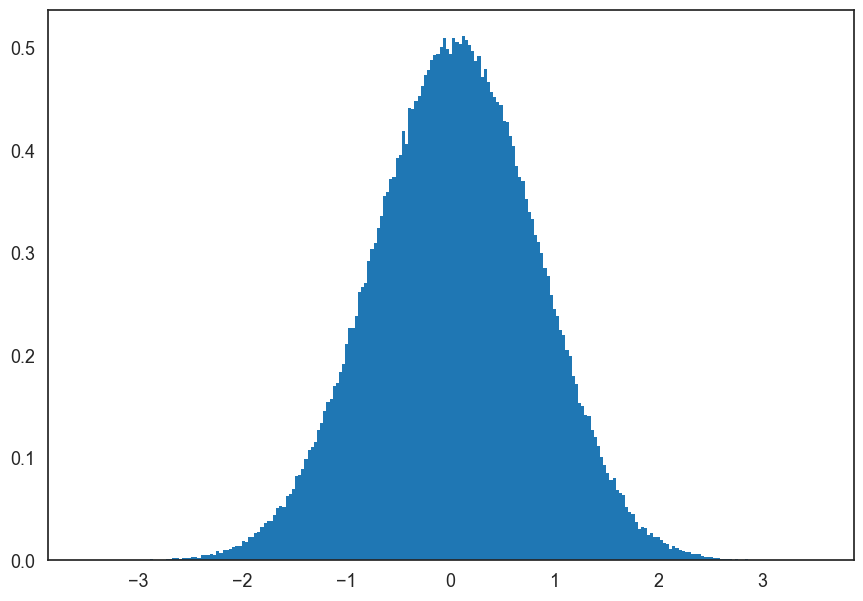

In [21]:
# Plot histogram of Random field result
plt.hist(field.field, bins='fd', density=True);

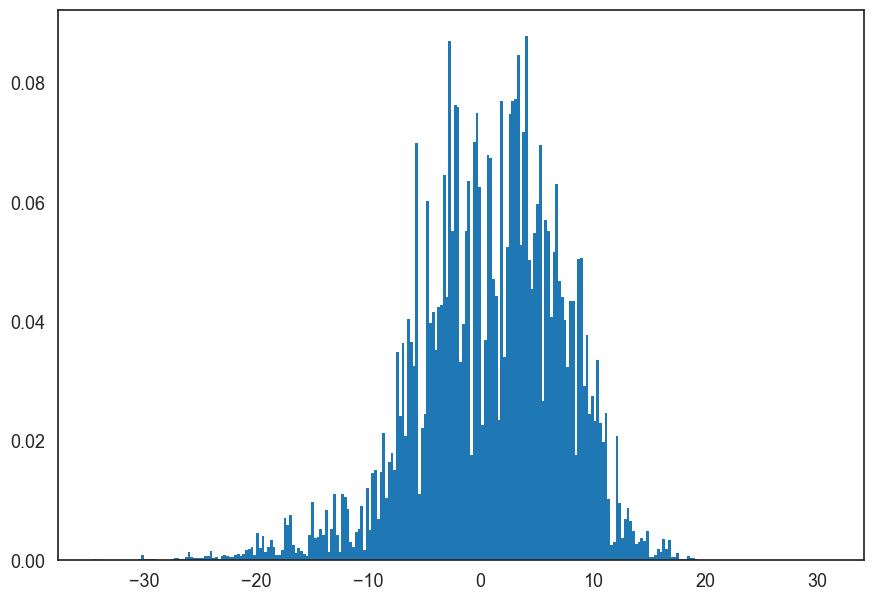

In [22]:
# N-score back-transform
back_transformed = from_norm(field.field, inv, param, m, sd)
plt.hist(back_transformed, bins='fd', density=True);

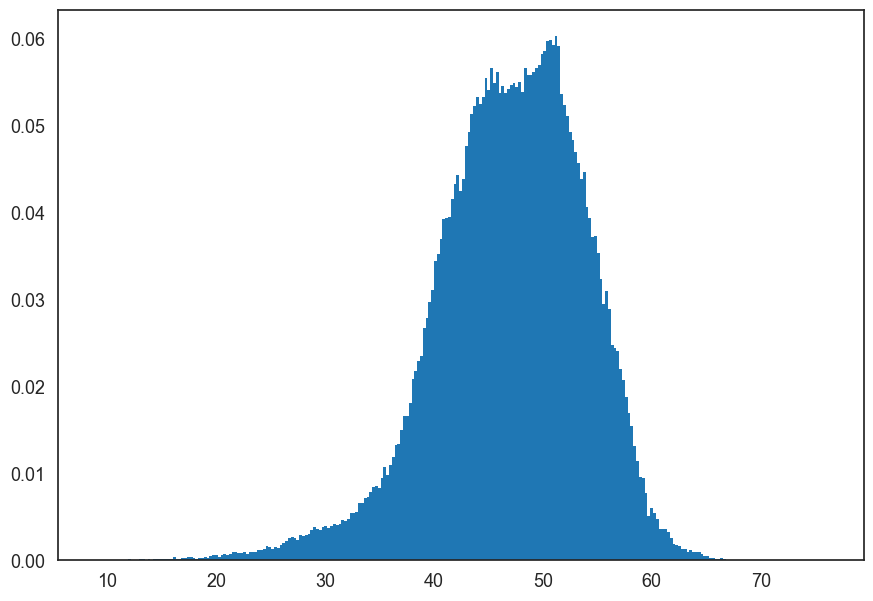

In [23]:
# Reapply trends
# Add linear y trend back
retrended_temp = back_transformed + linear_trend(field.pos[1,:], *popt_lin)
# Add exponential z trend back
retrended = retrended_temp + exponential_trend(field.pos[2,:], *popt_exp)

plt.hist(retrended, bins='fd', density=True);

In [24]:
# Overwrite field result with back_transformed and retrended data
field.field=retrended

In [25]:
# Plot simulated field and drillhole data
p = plot_block_model(field)

# Vertical exaggeration
p.set_scale(zscale=30)

p.show()

### 5. Complete Model



In [26]:
%%time
# Routine to calculate for all sequences:

# Empty dict for results
res_dict = {}

# Calculate model for each sequence
for unit in variogram_results["Sequence"].values:
    
    # Extract domain
    domain_x, domain_y, domain_z = extract_domain(sol, ref_dict2[unit])
    
    # Create Gaussian field
    field = perform_SGS(domain_x, domain_y, domain_z, 
                    strike_angle=variogram_results[variogram_results["Sequence"]==unit]["X Angle (Attr)"].values[0], 
                    dip_angle=variogram_results[variogram_results["Sequence"]==unit]["Y Angle (Attr)"].values[0], 
                    cond_data=np.hstack((df[df["Sequence"]==unit].values[:,:3].astype("float64"), 
                                df["Nscore Residuals"][df["Sequence"]==unit].values.astype("float64").reshape(-1,1))), 
                    x_range=variogram_results[variogram_results["Sequence"]==unit]["X Range (Attr)"].values[0], 
                    y_range=variogram_results[variogram_results["Sequence"]==unit]["Y Range (Attr)"].values[0], 
                    z_range=variogram_results[variogram_results["Sequence"]==unit]["Z Range (Well Data)"].values[0])
    
    # Back-transform and reapply trends
    back_transformed = from_norm(field.field, inv, param, m, sd)
    retrended_temp = back_transformed + linear_trend(field.pos[1,:], *popt_lin)
    retrended = retrended_temp + exponential_trend(field.pos[2,:], *popt_exp)
    
    field.field=retrended
    
    res_dict[unit]=field
    

    
    

CPU times: total: 2min 41s
Wall time: 2min 41s


In [28]:
# Create single dataframe with unified results
results_df  = pd.DataFrame(columns=("X", "Y", "Z", "Porosity", "Sequence"))

for unit in variogram_results["Sequence"].values:
    
    temp_list =  np.empty(len(res_dict[unit].pos[0,:]), dtype='U100')
    temp_list[:] = unit

    temp_df = pd.DataFrame(
        np.array([res_dict[unit].pos[0,:],
        res_dict[unit].pos[1,:],
        res_dict[unit].pos[2,:],
        res_dict[unit].field,
        temp_list]).T, columns=("X", "Y", "Z", "Porosity", "Sequence"))
    
    results_df = pd.concat([results_df, temp_df])
    

results_df = results_df.astype({'X': 'float64', 'Y': 'float64', 'Z': 'float64', 'Porosity': 'float64',})

results_df

,X,Y,Z,Porosity,Sequence
0,250.0,250.0,-30.0,39.13,m1
1,250.0,750.0,-30.0,41.20,m1
2,250.0,1250.0,-30.0,37.52,m1
3,250.0,1750.0,-30.0,34.10,m1
4,250.0,2250.0,-30.0,32.53,m1
...,...,...,...,...,...
253698,68750.0,133750.0,-1530.0,46.40,o1
253699,68750.0,133750.0,-1510.0,46.43,o1
253700,68750.0,133750.0,-1490.0,47.46,o1
253701,68750.0,133750.0,-1470.0,32.92,o1


In [29]:
# Plot full model without gempy

#cmap = plt.cm.get_cmap("viridis", 6)
p = pvqt.BackgroundPlotter()

pc = pv.PolyData(np.c_[results_df["X"].values, results_df["Y"].values, results_df["Z"].values])

pc["Porosity"]=results_df["Porosity"].values

spacing = lambda arr: np.unique(np.diff(np.unique(arr)))
voxelsize = spacing(pc.points[:,0]), spacing(pc.points[:,1]), spacing(pc.points[:,2])

pc = pc.cast_to_unstructured_grid()

grid = PVGeo.filters.VoxelizePoints(dx=voxelsize[0][0], dy=voxelsize[1][0], dz=voxelsize[2][0], estimate=False).apply(pc)
    
#p.add_mesh(grid, opacity=1, show_edges=False, lighting=False, cmap=cmap)
#p.add_mesh(grid, opacity=1, show_edges=False, lighting=False, cmap="viridis")
#p.add_mesh(grid, scalars="Porosity", opacity=1, show_edges=False, lighting=False, cmap="viridis")
p.add_mesh(grid, scalars="Porosity", opacity=1, show_edges=False, lighting=False, cmap="viridis", clim=[results_df["Porosity"].min(), results_df["Porosity"].max()])

p.set_scale(zscale=30)
p.camera_position = (-320, -200, 3)
p.show_grid(xlabel="X [m]", ylabel="Y [m]", zlabel="Z [m]")

p.show()

In [30]:
# Save realization as result to csv 
realization_name = str("Model_realization_"+datetime.datetime.now().strftime("%Y%m%d"))
results_df.to_csv("Results/"+realization_name+".csv", index=False)